In [69]:
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf

tf.keras.backend.set_floatx('float64')

%matplotlib inline

In [189]:
def compute_data(ttm, n_timesteps, n_samples, final_payoff, vol, spot=100.0, ba_spread = 0.0001):
    spot_bid = np.empty((n_samples, n_timesteps,))
    spot_ask = np.empty((n_samples, n_timesteps,))
    payoff = np.zeros((n_samples,n_timesteps,))
    timegrid = np.linspace(0.0, ttm, n_timesteps)
    call_ttm = np.empty((n_samples, n_timesteps,))
    simulated_spot = np.full((n_samples,), spot)
    spot_bid[:,0] = simulated_spot*(1.0-ba_spread*0.5)
    spot_ask[:,0] = simulated_spot*(1.0+ba_spread*0.5)
    
    for i in range(n_samples):
        call_ttm[i,:] = ttm-timegrid
    
    vol_2 = vol**2
    for i in range(1,timegrid.shape[0]):
        dt = timegrid[i]-timegrid[i-1]
        rand = np.random.standard_normal((n_samples,))
        simulated_spot = simulated_spot * np.exp((- 0.5 * vol_2) * dt +
                                         vol * np.sqrt(dt) * rand)
        spot_bid[:,i] = simulated_spot*(1.0-ba_spread*0.5)
        spot_ask[:,i] = simulated_spot*(1.0+ba_spread*0.5)
    payoff[:,-1] = final_payoff(simulated_spot)
    return np.atleast_3d(spot_bid), np.atleast_3d(spot_ask), np.atleast_3d(call_ttm), np.atleast_3d(payoff)

def call_payoff(strike):
    def c(x):
        return np.maximum(x-strike, 0.0)
    return c

spot_bid, spot_ask, call_ttm, payoff = compute_data(1.0, n_timesteps=120, n_samples=5000, final_payoff=call_payoff(strike=100.0), vol=0.2)
f_hedge=np.concatenate([spot_bid, call_ttm], axis=2)

In [190]:
@tf.function
def expected_shortfall_10pct(y_true, y_pred):
    pnl = tf.keras.backend.reshape(y_pred - y_true, (-1, ))
    pnl = tf.multiply(pnl, -1.0)

    n_pct = tf.keras.backend.round(tf.multiply(
        tf.keras.backend.cast(tf.keras.backend.shape(pnl)[0], tf.float32)  , 0.1))

    pnl_past_cutoff = tf.nn.top_k(pnl, tf.keras.backend.cast(n_pct, tf.int32))[0]
    return tf.reduce_mean(pnl_past_cutoff)

##===============================================================
## CLASSES
##===============================================================

class Hedger(tf.keras.Model):
    def __init__(
        self,
        n_features,
        model_param):

        # call parent class
        super(Hedger, self).__init__()

        # init hedge model
        self.hedge_model = HedgeModel(model_param['units'], model_param['activations'], n_features)

        # init cashflow model
        self.cf_model = CashflowModel()

    def call(self, inputs, training=None):
        f_hedge = inputs[0]
        hedge_qty = self.hedge_model.call(f_hedge, training=training)
        f_loss = [hedge_qty] + inputs[1:]
        loss_cf = self.cf_model.call(f_loss, training=training)
        return loss_cf
        
class HedgeModel(tf.keras.Model):
    def __init__(
        self,
        units,
        activations, n_features):

        super(HedgeModel, self).__init__()

        # Checks
        if units[-1] != 1:
            raise ValueError('Last unit must be 1, because it specifies the hedge quantity for the underlying stock.')

        # Members
        self.n_units = len(units)
        
        # Dense layer
        self.lay_dnn_0 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units[0], activation=activations[0], input_shape=(None,n_features)))
        for k in range(1, len(units)-1):
            setattr(
                self,
                'lay_dnn_' + str(k), 
                tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units[k], activation=activations[k]))
            )
        self.lay_hedge_qty = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(units[-1], activation=activations[-1], name='hedge_qty_layer')
            )

    def call(self, feat_input, training=False):
        ten_dnn = self.lay_dnn_0(feat_input)
        for k in range(1, self.n_units - 1):
            ten_dnn = getattr(self, 'lay_dnn_' + str(k))(ten_dnn)
        ten_dnn = self.lay_hedge_qty(ten_dnn)
        return ten_dnn

class CashflowModel(tf.keras.Model):

    def __init__(self):
        super(CashflowModel, self).__init__()
        # hedge cashflows from trades
        self.dqty_inner = tf.keras.layers.Lambda(lambda x: x[:,1:] - x[:,:-1])        
        self.dqty0 = tf.keras.layers.Lambda(lambda x: tf.keras.backend.reshape(x[:,0,:], shape=(-1,1,1)))
        self.dqtyT = tf.keras.layers.Lambda(lambda x: tf.keras.backend.reshape(-x[:,-1,:], shape=(-1,1,1)))
        self.dqty = tf.keras.layers.Concatenate(axis=1)

        self.dqty_pos = tf.keras.layers.Lambda(lambda x: tf.keras.backend.minimum(-1.0*x, 0.0))
        self.dqty_neg = tf.keras.layers.Lambda(lambda x: tf.keras.backend.maximum(-1.0*x, 0.0))

        self.hedge_cashflow_buy = tf.keras.layers.Multiply()
        self.hedge_cashflow_sell = tf.keras.layers.Multiply()
        self.hedge_cashflow_trades = tf.keras.layers.Add(name='hedge_cashflow_trades')

        # hedge cashflows from payoffs
        #self.qty_layer_initial = tf.keras.layers.Lambda(lambda x: tf.keras.backend.reshape(tf.zeros_like(x[:,0,:]),(-1,1,1)))
        #self.qty_layer_extended = tf.keras.layers.Concatenate(axis=1)
        #self.hedge_cashflow_payoff = tf.keras.layers.Multiply(name='hedge_cashflow_payoff')
        
        # total hedge cashflows
        self.hedge_cashflow = tf.keras.layers.Add(name='hedge_cashflow')

        # cumulated cashflows that define the loss
        self.cashflow = tf.keras.layers.Add(name='cashflow_total')

        # aggregate loss output
        self.loss_value = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(tf.keras.backend.sum(x, axis=1), axis=-1, keepdims=True), name='loss')#(loss_timestep)


    def call(self, loss_inputs, training=False):
        # required order of loss_inputs = [hedge_qty, hedge_prc_bid, hedge_prc_ask, inst_payoff]
        hedge_qty = loss_inputs[0]
        hedge_prc_bid = loss_inputs[1]
        hedge_prc_ask = loss_inputs[2]
        inst_payoff = loss_inputs[3]
        
        # compute cumulated cashflows from hedge trades and instrument payoff
        dqty_inner = self.dqty_inner(hedge_qty)
        dqty0 = self.dqty0(hedge_qty)
        dqtyT = self.dqty0(hedge_qty)
        dqty = self.dqty([dqty0, dqty_inner, dqtyT])

        dqty_pos = self.dqty_pos(dqty)
        dqty_neg = self.dqty_neg(dqty)

        hedge_cf_buy = self.hedge_cashflow_buy([dqty_pos, hedge_prc_ask])
        hedge_cf_sell = self.hedge_cashflow_sell([dqty_neg, hedge_prc_bid])
        hedge_cf_trades = self.hedge_cashflow_trades([hedge_cf_buy, hedge_cf_sell])
        
        
        #hedge_cf = self.hedge_cashflow([hedge_cf_trades, hedge_cf_payoff])

        cashflow = self.cashflow([inst_payoff, hedge_cf_trades])
        
        loss_value = self.loss_value(cashflow)

        return loss_value


In [191]:
model_param = {
    'units': [8, 5, 1], 
    'activations': ['tanh', 'tanh', 'linear']
}

hedger = Hedger(f_hedge.shape[-1], model_param)

In [206]:
optim = tf.keras.optimizers.Adam(lr=0.000005)
if True:
    loss_fcn = 'mean_squared_error'
else:
    loss_fcn = expected_shortfall_10pct

hedger.compile(optimizer=optim, loss=loss_fcn)

In [207]:
date = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'C:\\temp\\deep_hedging\\' + date
cb = [tf.keras.callbacks.TensorBoard(profile_batch=0, 
                            log_dir=log_dir, histogram_freq=100),]
cb.append(tf.keras.callbacks.ModelCheckpoint(log_dir + '\\best_model.h5', save_best_only = True))

history = hedger.fit([f_hedge[:,:-1,:], spot_bid, spot_ask, payoff], np.zeros((spot_bid.shape[0],1)), 
                     epochs=400, batch_size=500, callbacks=cb, verbose=0, validation_split=0.2)

In [208]:
delta = hedger.hedge_model.predict(f_hedge[:,:-1,:])

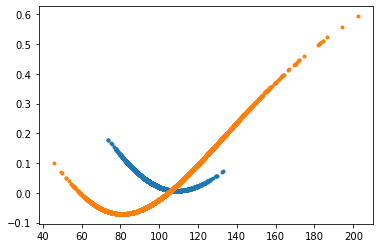

In [209]:
#plt.plot(spot_bid[:,-1,0],payoff[:,-1,0],'.')
#plt.figure()
plt.plot(spot_bid[:,20,0],delta[:,20,0],'.')
plt.plot(spot_bid[:,118,0],delta[:,118,0],'.')
#plt.plot(spot_ask[:,20,0],delta[:,20,0],'.')
#plt.plot(spot_ask[:,100,0],delta[:,100,0],'.')

(array([  2.,  13.,  58., 161., 245., 277., 154.,  65.,  17.,   8.]),
 array([ 79.90781774,  83.83117003,  87.75452232,  91.67787461,
         95.6012269 ,  99.52457918, 103.44793147, 107.37128376,
        111.29463605, 115.21798834, 119.14134063]),
 <a list of 10 Patch objects>)

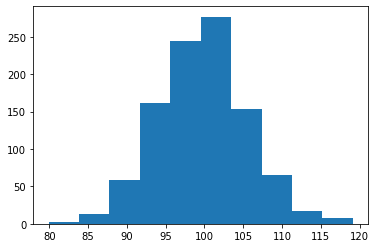

In [132]:
plt.hist(spot_bid[:,10,0])